In [20]:
from src.AutoCoder import AutoCoder, Optim_autocoder, SGD_autocoder
from src.LinearModel import Linear
from src.NonLinearModel import Sigmoid, Tanh
from src.Loss import MSELoss, BCELoss
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [21]:
batch = 64
input = 256
output1 = 128
output2 = 64
output3 = 20
output4 = 10

epochs = 100


#### Test on random data

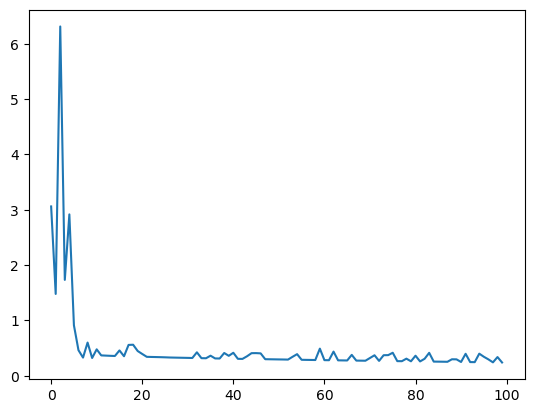

In [22]:
X = np.random.randn(5000, 256)
autocoder = AutoCoder(Linear(input, output1), Sigmoid(), Linear(output1, output2), Sigmoid())
optim = Optim_autocoder(autocoder, BCELoss(), 0.0001)
scores = []

for iteration in range(epochs):
    optim.clean_output()
    optim.zero_score()
    optim.step(X)
    optim.update_output()
    scores.append(optim.score.mean())


plt.plot(np.arange(epochs), scores)
plt.show()

$exp(X)$ will overflow if we have too much layers.
**So we choose to have a auto-coder with two layers**

#### Visualize reconstructed images after a compression.

In [23]:
barbara = np.array(Image.open('../../img/barbara.png'))
print(barbara.shape)


(512, 512)


In [24]:
barbara_norm = barbara / 255

print(barbara_norm.max())

0.9647058823529412


In [25]:
batch = 32
input = 512
output1 = 256
output2 = 128
output3 = 64
output4 = 10

epochs = 500

In [26]:
autocoder_barbara = AutoCoder(Linear(input, output1), Sigmoid(), Linear(output1, output2), Sigmoid(), Linear(output2, output3), Sigmoid(), Linear(output3, output4), Sigmoid())
optim_barbara = Optim_autocoder(autocoder_barbara, BCELoss(), 1e-13)
scores = []

for iteration in range(epochs):
    optim_barbara.clean_output()
    optim_barbara.zero_score()
    optim_barbara.step(barbara_norm)
    optim_barbara.update_output()
    scores.append(optim_barbara.score.mean())

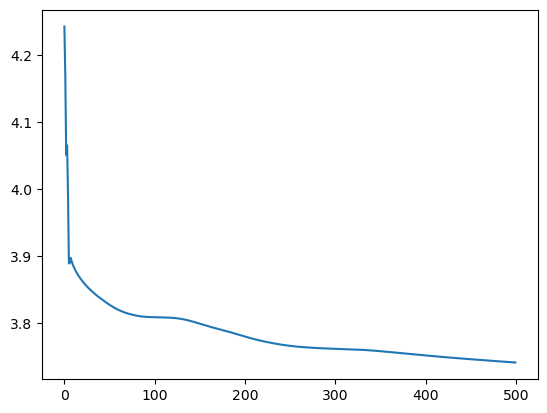

In [27]:
plt.plot(np.arange(epochs), scores)
plt.show()

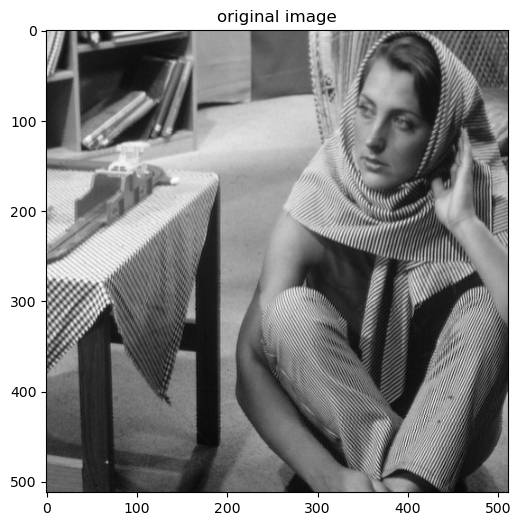

In [28]:
plt.figure(figsize=(500//80,500//80))
plt.gray()
plt.imshow(barbara_norm) 
plt.title('original image')
plt.show()

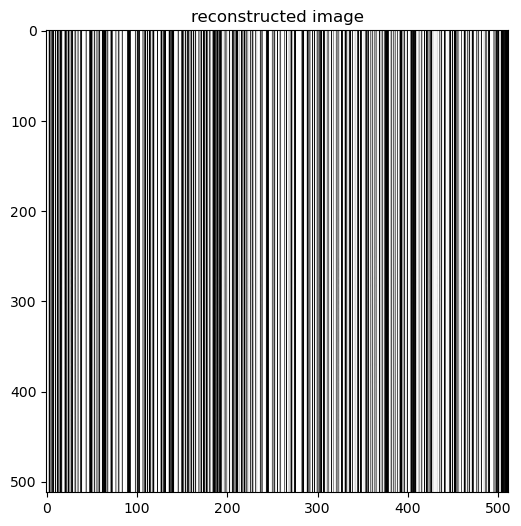

In [29]:
plt.figure(figsize=(500//80,500//80))
plt.gray()
plt.imshow(optim_barbara.x_hat) 
plt.title('reconstructed image')
plt.show()

#### We can find that the image reconstructed from the latent dimension loses all the spatial information. Therefore, the autocoder method can't be used in image's compression.

#### preprocessing data

In [30]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    return tmpx,tmpy

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")
    plt.show()

In [31]:
path_to_train = '../../data/USPS_train.txt'
path_to_test = '../../data/USPS_test.txt'

X_train, y_train = load_usps(path_to_train)
X_test, y_test = load_usps(path_to_test)

X_train = X_train / X_train.max(axis=1).reshape(X_train.shape[0], 1)
X_test = X_test / X_test.max(axis=1).reshape(X_test.shape[0], 1)


In [32]:
batch = 64
input = 256
output1 = 128
output2 = 64


epochs = 500

**Train Set**

In [33]:
autocoder_multi_class = AutoCoder(Linear(input, output1), Sigmoid(), Linear(output1, output2), Sigmoid())
optim_multi_class = Optim_autocoder(autocoder_multi_class, BCELoss(), 1e-13)

scores = []

for iteration in range(epochs):
    optim_multi_class.clean_output()
    optim_multi_class.zero_score()
    optim_multi_class.step(X_train)
    optim_multi_class.update_output()
    scores.append(optim_multi_class.score.mean())


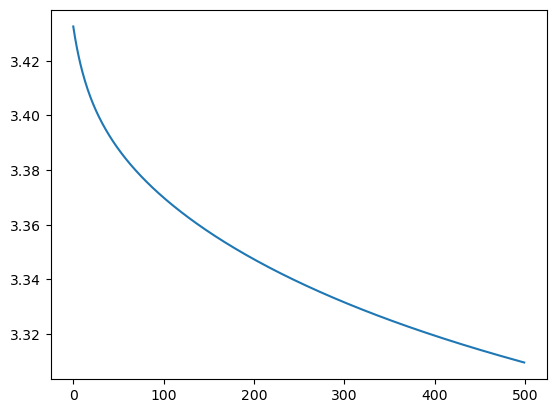

In [34]:
plt.plot(np.arange(epochs), scores)
plt.show()

In [44]:
batch = 32
input_multi_class = 64
output_multi_class1 = 20
output_multi_class2 = 10

epochs = 200

In [45]:
from src.SequentielNet import Sequentiel, Optim, SGD
from src.Loss import CELossSoftMax

net = Sequentiel(Linear(input_multi_class, output_multi_class1), Sigmoid(), Linear(output_multi_class1, output_multi_class2))
optim = SGD(net, optim_multi_class.autocoder.encoder.outputs[-1], y_train, batch, epochs, CELossSoftMax(), eps=0.1)

In [46]:
from sklearn.metrics import accuracy_score
def softmax(X):
    return np.exp(X) / np.exp(X).sum()

pred = np.argmax(softmax(optim.yhat), axis=1)
print(f'accuracy : {accuracy_score(y_train, pred)}')

accuracy : 0.8024962282265807


**Test Set**

In [47]:
optim_multi_class.clean_output()
optim_multi_class.zero_score()
optim_multi_class.step(X_test)
optim_multi_class.update_output()

In [48]:
optim.clean_output()
optim.step(optim_multi_class.autocoder.encoder.outputs[-1], y_test)
optim.update_output()

pred_test = np.argmax(softmax(optim.yhat), axis=1)
print(f'accuracy : {accuracy_score(y_test, pred_test)}')

accuracy : 0.7433981066268062


#### Conclusion
**We can find that the learning of data compressed is faster than that with data not compressed. Therefore, learning with compressed data can get a stable result in a small calculation. 
However, its upper limit is not as high as that of uncompressed data. (Within the same number of iteration, the accuracy with compressed data is a litte lower than that with original data)**